In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import random
import transformers as ppb
from wordcloud import WordCloud;
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import f1_score
from tqdm import notebook
from nltk.util import ngrams
import re,string
import unicodedata
from nltk.corpus import stopwords
import multiprocessing
from gensim.models import Word2Vec
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


%matplotlib inline

Загрузка датасета

In [2]:
train = pd.read_csv('data/train.csv', encoding="utf-8-sig").sample(18000)
test = pd.read_csv('data/test.csv', encoding="utf-8-sig").sample(1000)

train_vec = pd.read_csv('data/train.csv', encoding="utf-8-sig")
test_vec = pd.read_csv('data/test.csv', encoding="utf-8-sig")

Предобработка текста

In [3]:
combi = train.append([], ignore_index=True)
combi_boy_tfidf = train_vec.append(test_vec, ignore_index=True)

C:\Users\maxim\AppData\Local\Temp\ipykernel_16852\501864639.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combi = train.append([], ignore_index=True)
C:\Users\maxim\AppData\Local\Temp\ipykernel_16852\501864639.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combi_boy_tfidf = train_vec.append(test_vec, ignore_index=True)


In [4]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)

  return input_txt

In [5]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "#[\w]*|@[\w]*")
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z]", " " )
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

combi_boy_tfidf['tidy_tweet'] = np.vectorize(remove_pattern)(combi_boy_tfidf['tweet'], "@[\w]*")
combi_boy_tfidf['tidy_tweet'] = combi_boy_tfidf['tidy_tweet'].str.replace("[^a-zA-Z#]", " " )
combi_boy_tfidf['tidy_tweet'] = combi_boy_tfidf['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


C:\Users\maxim\AppData\Local\Temp\ipykernel_16852\4208400461.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z]", " " )
C:\Users\maxim\AppData\Local\Temp\ipykernel_16852\4208400461.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  combi_boy_tfidf['tidy_tweet'] = combi_boy_tfidf['tidy_tweet'].str.replace("[^a-zA-Z#]", " " )


In [6]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet_tfidf = combi_boy_tfidf['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet_tfidf

0        [when, father, dysfunctional, selfish, drags, ...
1        [thanks, #lyft, credit, cause, they, offer, wh...
2                                  [bihday, your, majesty]
3                         [#model, love, take, with, time]
4                       [factsguide, society, #motivation]
                               ...                        
49154    [thought, factory, left, right, polarisation, ...
49155    [feeling, like, mermaid, #hairflip, #neverread...
49156    [#hillary, #campaigned, today, #ohio, used, wo...
49157    [happy, work, conference, right, mindset, lead...
49158    [song, glad, free, download, #shoegaze, #newmu...
Name: tidy_tweet, Length: 49159, dtype: object

In [7]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet_tfidf = tokenized_tweet_tfidf.apply(lambda x: [stemmer.stem(i) for i in x])

tokenized_tweet_tfidf

0        [when, father, dysfunct, selfish, drag, kid, i...
1        [thank, #lyft, credit, caus, they, offer, whee...
2                                  [bihday, your, majesti]
3                         [#model, love, take, with, time]
4                             [factsguid, societi, #motiv]
                               ...                        
49154    [thought, factori, left, right, polaris, #trum...
49155    [feel, like, mermaid, #hairflip, #neverreadi, ...
49156    [#hillari, #campaign, today, #ohio, use, word,...
49157    [happi, work, confer, right, mindset, lead, cu...
49158    [song, glad, free, download, #shoegaz, #newmus...
Name: tidy_tweet, Length: 49159, dtype: object

In [8]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

for i in range(len(tokenized_tweet_tfidf)):
    tokenized_tweet_tfidf[i] = ' '.join(tokenized_tweet_tfidf[i])

combi['tidy_tweet'] = tokenized_tweet
combi_boy_tfidf['tidy_tweet'] = tokenized_tweet_tfidf

combi

,id,label,tweet,tidy_tweet
0,28408,0,"what is the #world coming to? so much #hatred,...",what come much veri hear about stay
1,10261,0,sweet family stay @user @user @user #lov...,sweet famili stay
2,19456,0,i want my own human hamster wheel too the ult...,want human hamster wheel ultim stand desk
3,9549,0,@user the teens in the book club are so excit...,teen book club excit meet talk about incred me...
4,25113,0,* lushâð #bathbomb #pink #blue #bubble ...,lush
...,...,...,...,...
17995,1078,0,can #lighttherapy help with or #depression? ...,help with
17996,19382,0,sta uni placement this week. #personaltraini...,placement thi week
17997,12899,0,2016 and things like this still happen. when w...,thing like thi still happen when will peopl learn
17998,30171,0,awork from #myt #saturdayfreedom #love ð,awork from


Визуализация данных

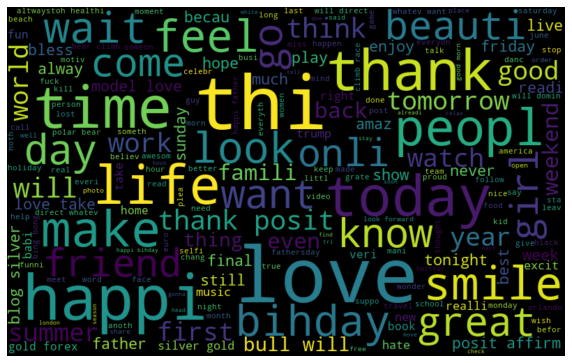

In [9]:
all_words = ' '.join([text for text in combi_boy_tfidf['tidy_tweet']])
wordcloud = WordCloud(width=800,height=500, random_state=21,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

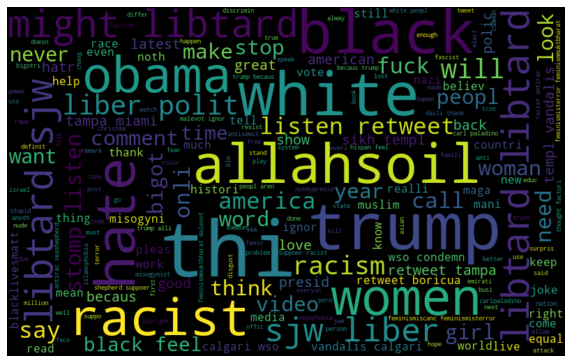

In [10]:
negativ_words = ' '.join([text for text in combi_boy_tfidf['tidy_tweet'][combi_boy_tfidf['label'] == 1]])
wordcloud = WordCloud(width=800,height=500, random_state=21,max_font_size=110).generate(negativ_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

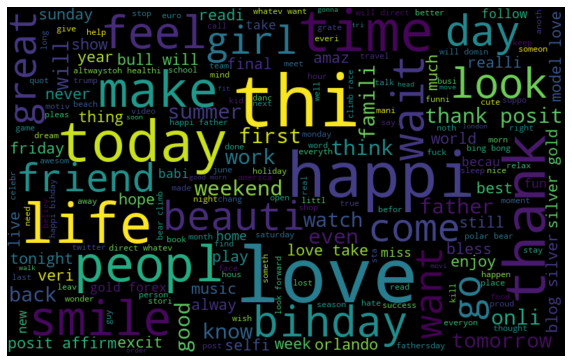

In [11]:
positiv_words = ' '.join([text for text in combi_boy_tfidf['tidy_tweet'][combi_boy_tfidf['label'] == 0]])
wordcloud = WordCloud(width=800,height=500, random_state=21,max_font_size=110).generate(positiv_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
  
HT_regular = hashtag_extract(combi_boy_tfidf['tidy_tweet'][combi_boy_tfidf['label'] == 0])

HT_negative = hashtag_extract(combi_boy_tfidf['tidy_tweet'][combi_boy_tfidf['label'] == 1])

HT_regular = sum(HT_regular, [])
HT_negative = sum(HT_negative, [])

Положительные и отрицательные

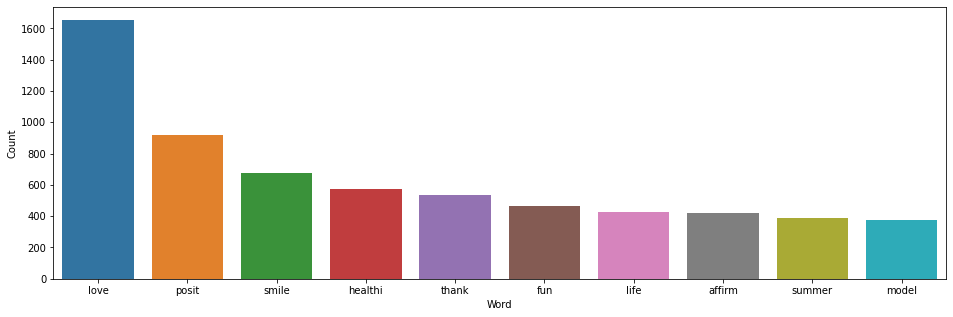

In [13]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})

d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=d, x = "Word", y="Count")
ax.set(ylabel = 'Count')
plt.show()

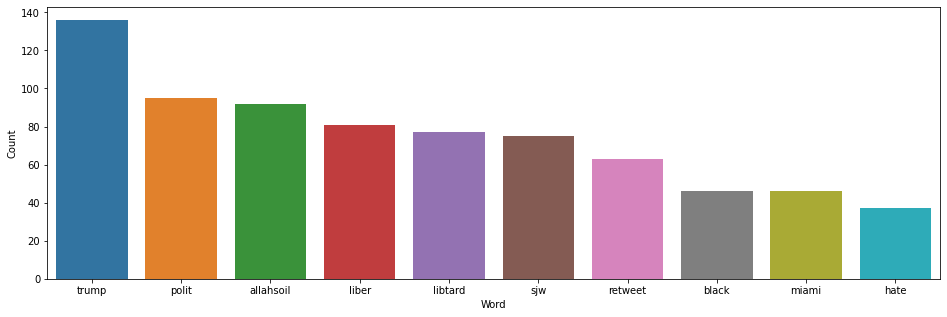

In [14]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Word': list(b.keys()),
                  'Count': list(b.values())})

e = e.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=e, x = "Word", y="Count")
ax.set(ylabel = 'Count')
plt.show()

Обучение модели

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

bow = bow_vectorizer.fit_transform(combi_boy_tfidf['tidy_tweet'])

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(combi_boy_tfidf['tidy_tweet'])

In [16]:
train_bow = bow[:31962, :]
test_bow = bow[31962:, :]

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_vec['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)

prediction = lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid,prediction_int)

C:\Users\maxim\AppData\Local\Temp\ipykernel_16852\1174778822.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


0.5303408146300915

In [17]:
train_tfidf = tfidf[:31962, :]
test_tfidf = tfidf[31962:, :]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:, 1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid,prediction_int)


C:\Users\maxim\AppData\Local\Temp\ipykernel_16852\1673240025.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction_int = prediction_int.astype(np.int)


0.5451327433628319

Синонимы слов, близость пар слов, лишнее слово

In [18]:
import zipfile
import gensim
with zipfile.ZipFile('./data/180.zip', 'r') as archive:
   stream = archive.open('model.bin')
   model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [19]:
words = ['день_NOUN', 'ночь_NOUN', 'человек_NOUN', 'семантика_NOUN', 'студент_NOUN', 'студентка_ADJ']
for word in words:
   if word in model:
       print(word)
       for i in model.most_similar(positive=[word], topn=3):
           print(i[0], i[1])
       print('\n')
   else:
       print(word + ' такого слова нет')

день_NOUN
неделя_NOUN 0.7375996112823486
день_PROPN 0.706766664981842
месяц_NOUN 0.7037326097488403


ночь_NOUN
ночь_PROPN 0.8310787081718445
вечер_NOUN 0.7183678150177002
рассвет_NOUN 0.6965947151184082


человек_NOUN
человек_PROPN 0.7850059270858765
человеческий_ADJ 0.5915265679359436
существо_NOUN 0.5736929774284363


семантика_NOUN
семантический_ADJ 0.8019332885742188
синтаксический_ADJ 0.7569340467453003
модальный_ADJ 0.7296056747436523


студент_NOUN
преподаватель_NOUN 0.6743764281272888
студенческий_ADJ 0.6486333012580872
университетский_ADJ 0.6442698836326599


студентка_ADJ такого слова нет


In [20]:
# Косинусную близость пары слов
print(model.similarity('ночи_NOUN', 'полночь_NOUN'))

0.4852951


In [21]:
# Лишнее слово в группе
print(model.doesnt_match('день_NOUN ночь_NOUN человек_NOUN студент_ADJ'.split()))

человек_NOUN


In [22]:
# Топ-N наиболее похожих слов. Положительные слова положительно влияют на сходство, отрицательные — отрицательно.
model.most_similar(positive=['отец_NOUN', 'мужчина_NOUN'], negative=['сын_NOUN'])

[('женщина_NOUN', 0.6815640926361084),
 ('мужчина_PROPN', 0.6580325365066528),
 ('женщина_PROPN', 0.5984241962432861),
 ('мужской_ADJ', 0.5404039025306702),
 ('взрослый_ADJ', 0.46114426851272583),
 ('девушка_NOUN', 0.4559611976146698),
 ('женский_ADJ', 0.4559462070465088),
 ('гомосексуал_NOUN', 0.4475041925907135),
 ('гендерный_ADJ', 0.4338761270046234),
 ('фригидный_ADJ', 0.4250812232494354)]

N-Gramm

In [23]:
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [24]:
words = basic_clean(''.join(combi['tidy_tweet']))

In [25]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]

Text(0.5, 0, 'Частостаs')

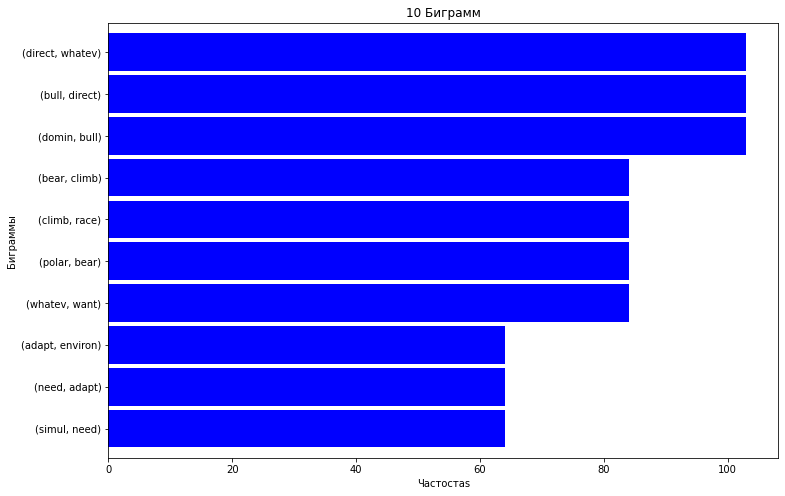

In [26]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Биграмм')
plt.ylabel('Биграммы')
plt.xlabel('Частостаs')

Text(0.5, 0, 'Частоста')

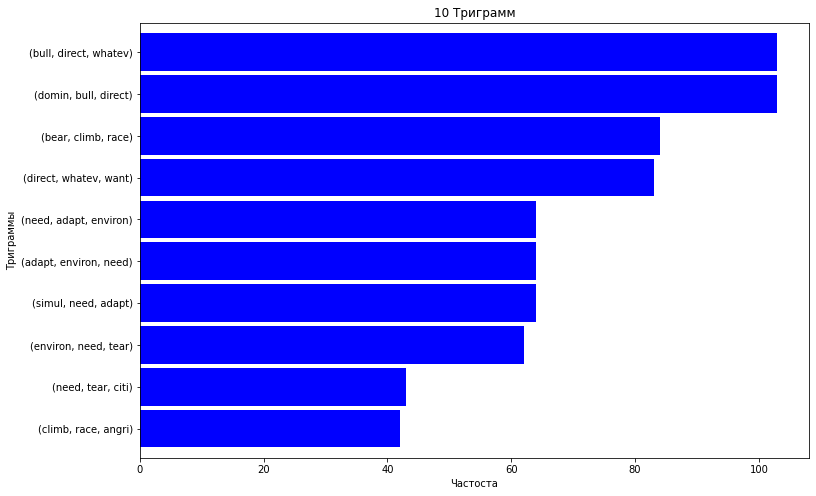

In [27]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Триграмм')
plt.ylabel('Триграммы')
plt.xlabel('Частоста')

Контекстуализированные представления

In [28]:
tokenizer = ppb.BertTokenizer(vocab_file='./data/bert/vocab.txt') 

In [29]:
tokenized = combi['tidy_tweet'].apply((lambda x: tokenizer.encode(x)))
print(tokenized[0])
print(tokenizer.tokenize(combi['tidy_tweet'][0]))

[101, 2054, 2272, 2172, 2310, 3089, 2963, 2055, 2994, 102]
['what', 'come', 'much', 've', '##ri', 'hear', 'about', 'stay']


In [30]:
config = ppb.BertConfig.from_json_file('./data/bert/config.json')
model = ppb.BertModel.from_pretrained('./data/bert/model.bin', config = config) 

Some weights of the model checkpoint at ./data/bert/model.bin were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [32]:
np.array(padded).shape

(18000, 37)

In [33]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape 

(18000, 37)

In [34]:
batch_size = 1000
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)): 
    input_ids = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    torch.no_grad()
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask_batch) 
    embeddings.append(last_hidden_states[0][:,0,:].numpy())

  0%|          | 0/18 [00:00<?, ?it/s]

In [35]:
features = np.concatenate(embeddings)
features.shape

(18000, 768)

In [36]:
labels = combi['tidy_tweet']
labels.shape

(18000,)

In [37]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels) 
lr_clf = LogisticRegression(max_iter=200)
lr_clf.fit(train_features, train_labels) 

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [38]:
tweet_index = random.randint(1,500)
print('Text: ' + combi['tweet'][tweet_index])
print('Predict label: ', lr_clf.predict(features[tweet_index:tweet_index+1][:])[0])
print('True label: ', combi['tidy_tweet'][combi['label'] == 0][tweet_index]) 
lr_clf.score(test_features, test_labels) 

Text: instead of the usual #ripdad  fathersday  here's something new for a change &amp; boy i'm   btw #itsaboy 
Predict label:  instead usual fathersday here someth chang
True label:  instead usual fathersday here someth chang


0.20177777777777778